# Developing Drosophila (Stereo-seq)

In [26]:
import sys
sys.path.append('E:/Anaconda/envs/SpaVAEW/Lib/site-packages/')

In [27]:
import glob
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

import SpaGTL

## Data loading and preprocessing

The Stereo-seq is available at stomicsDB (https://db.cngb.org/stomics/flysta3d/).
The list of marker genes can be obtained from the supplementary material of the article "High-resolution 3D spatiotemporal transcriptomic maps of developing Drosophila embryos and larvae".

In [28]:
marker=pd.read_csv("E:/data/Drosophila/Marker/STOmics_markers.csv",header=None)[0]
E16_adata=sc.read_h5ad('E:/data/Drosophila/E16-18h_a_count_normal_stereoseq.h5ad')
E16_adata.X=E16_adata.layers['raw_counts']
E16_adata=E16_adata[:,E16_adata.var_names&marker]

C:\Users\123\AppData\Local\Temp\ipykernel_5776\4275378682.py:8: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  E16_adata=E16_adata[:,E16_adata.var_names&marker]


## Spatial reconstruction

We perform spatial reconstruction to aggregate expression from spatial neighbors.

In [29]:
SpaGTL.spatial_reconstruction(E16_adata, alpha=2)

## Graph Transfer Learning

We perform graph transfer learning on the preprocessed data.

In [30]:
SpaGTL.run_SpaGTL(E16_adata, n_epochs=1000)

100%|█████████████████████████████████████████████████████████████| 1000/1000 [01:21<00:00, 12.32it/s, loss: 3.971e+03]


## Regulon inference and aucell

We perform regulon inference using gene relation matrix.

In [32]:
from yaml import Loader, Dumper
import glob
MOTIF_ANNOTATIONS_FNAME='E:/data/CisTarget/motifs-v9-nr.flybase-m0.001-o0.0.tbl'
tf_names=np.array((pd.read_table('E:/data/CisTarget/allTFs_dmel.txt',header=None).iloc[:,0]))
DATABASES_GLOB='E:/data/CisTarget/dm6*.feather'
db_fnames = glob.glob(DATABASES_GLOB)
SpaGTL.regulons(E16_adata, tf_names, MOTIF_ANNOTATIONS_FNAME, db_fnames, neighbors_var_key='QK')


2024-07-12 20:37:26,718 - pyscenic.utils - INFO - Creating modules.


Create regulons from a dataframe of enriched features.
Additional columns saved: []


We perform aucell to compute the activity of each regulon on each spot.

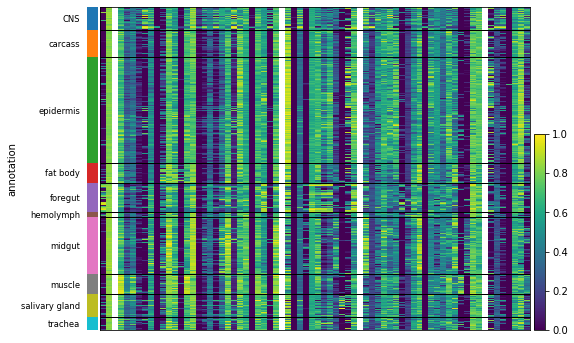

In [35]:
E16_adata.X=E16_adata.layers['x4']
SpaGTL.aucell(E16_adata, normalize=True)
SpaGTL.heatmap_aucell(E16_adata, E16_adata.obsm['aucell'].columns, groupby='annotation')

## Finding differentially activity regulons

We find the differentially activity regulons across identified domains and show the domains and their differentially activity regulons patterns in 3D spatial coordinates.

In [39]:
adata_aucell = sc.AnnData(E16_adata.obsm['aucell'])
adata_aucell.obs = E16_adata.obs.copy()
adata_aucell.obsm = E16_adata.obsm.copy()
adata_aucell.obsm['spatial'] = E16_adata.obsm['spatial']

In [40]:
sc.tl.rank_genes_groups(adata_aucell, groupby='annotation', method='t-test_overestim_var')

In [41]:
pd.DataFrame(adata_aucell.uns['rank_genes_groups']['names']).iloc[:10,:]

,CNS,carcass,epidermis,fat body,foregut,hemolymph,midgut,muscle,salivary gland,trachea
0,trv(+),oc(+),grh(+),srp(+),B-H1(+),bin(+),sug(+),ss(+),jim(+),Hey(+)
1,Sp1(+),vvl(+),en(+),Ets98B(+),SoxN(+),peb(+),Pdp1(+),CG7101(+),btd(+),Mef2(+)
2,D(+),en(+),gcm2(+),Hey(+),pb(+),maf-S(+),maf-S(+),Cf2(+),bs(+),bap(+)
3,fd59A(+),ovo(+),vvl(+),pnt(+),fd96Cb(+),pnr(+),grn(+),Mef2(+),SoxN(+),CG7101(+)
4,ara(+),sr(+),knrl(+),Max(+),toy(+),Pdp1(+),bin(+),bs(+),Cf2(+),svp(+)
5,Rfx(+),bap(+),slp1(+),pnr(+),pnr(+),Rfx(+),TFAM(+),CTCF(+),CG7101(+),HLH54F(+)
6,zfh1(+),Mef2(+),sr(+),grn(+),btd(+),SoxN(+),HLH54F(+),cyc(+),toy(+),ss(+)
7,ct(+),slp1(+),ovo(+),TFAM(+),sqz(+),E2f2(+),pnt(+),sr(+),fd59A(+),TFAM(+)
8,Rbp6(+),HLH54F(+),bap(+),BEAF-32(+),svp(+),CrebA(+),Stat92E(+),zfh1(+),pb(+),nau(+)
9,CrebA(+),cyc(+),ken(+),svp(+),E2f2(+),BEAF-32(+),BEAF-32(+),Hey(+),zfh1(+),pnt(+)


Here, we've created an interactive visualization window.

In [42]:
%matplotlib notebook
%matplotlib auto

Using matplotlib backend: nbAgg


We assign a color to each spot to distinguish the spatial domain.

In [43]:
def assign_colors(elements, color_map):
    """
    Assign colors to elements based on a predefined mapping.

    Parameters:
    - elements (list): List of elements to assign colors to.
    - color_map (dict): Dictionary mapping elements to their corresponding colors.

    Returns:
    - list: A list containing the colors assigned to each element.
    """
    colors = []
    # Iterate over the list of elements
    for element in elements:
        # Append the corresponding color from the color map
        if element in color_map:
            colors.append(color_map[element])
        else:
            colors.append('unknown')  # Default color if the element is not in the map

    return colors

elements = list(E16_adata.obs['annotation'])
color_map = {'CNS':'#7a4900',
 'amnioserosa':'#ffff00',
 'carcass':'#0000a6',
 'epidermis':'#FFBE7A',
 'epidermis/CNS':'#997d87',
 'fat body':'#008941',
 'fat body/trachea':'#1ce6ff',
 'foregut':'#63ffac',
 'foregut/garland cells':'#ff4a46',
 'hemolymph':'#ffdbe5',
 'hindgut':'#006fa6',
 'hindgut/malpighian tubule':'#8fb0ff',
 'midgut':'#ff34ff',
 'midgut/malpighian tubules':'#b79762',
 'muscle':'#004d43',
 'salivary gland':'#a30059',
 'testis':'#FA7F6F',
 'trachea':'#82B0D2'}

colors = assign_colors(elements, color_map)

Next, we show the spatial domain on 3D coordinates.

<IPython.core.display.Javascript object>


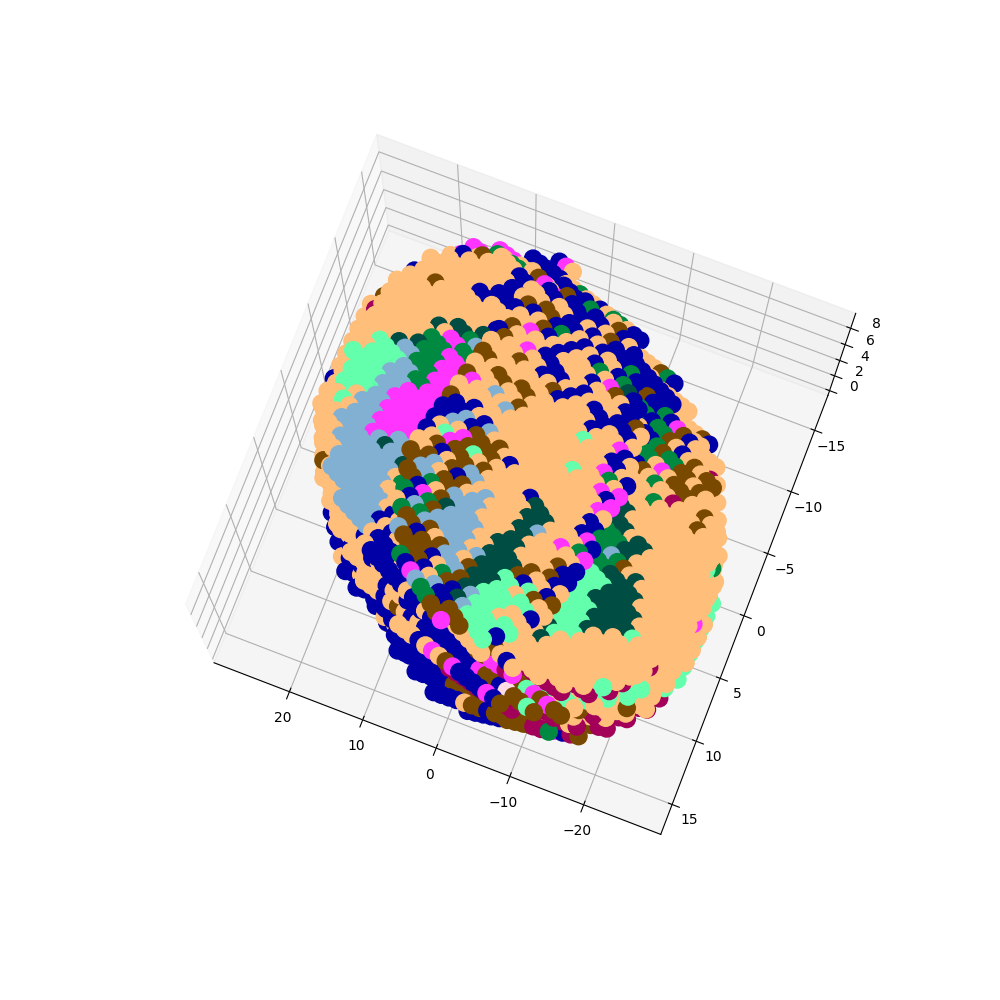

In [48]:
fig = plt.figure(figsize=(10,10))
ax3d = fig.add_subplot(111, projection='3d')
ax3d.scatter(E16_adata.obsm['spatial'][:,0], E16_adata.obsm['spatial'][:,1], E16_adata.obsm['spatial'][:,2],s = 150, c = colors, alpha =1)

Similarly, regulon activity can also be displayed on 3D coordinates.

In [92]:
#fig = plt.figure(figsize=(10,10))
#ax3d = fig.add_subplot(111, projection='3d')
#ax3d.scatter(E16_adata.obsm['spatial'][:,0], E16_adata.obsm['spatial'][:,1], E16_adata.obsm['spatial'][:,2],s = 150, c = E16_adata.obsm['aucell']['grh(+)'], alpha =1)

To better observe the region control pattern, we mapped 3D coordinates to 2D coordinates.

In [70]:
%matplotlib inline

In [71]:
coord=pd.DataFrame(adata_aucell.obsm['spatial'])
adata_aucell.obsm['spatial'] = np.matmul(coord.iloc[:,[0,1]].to_numpy(),[[np.cos(45), -np.sin(45)],[np.sin(45), np.cos(45)]])
sc.pp.scale(adata_aucell)
adata_aucell.X = np.clip(adata_aucell.X, a_min=-2.5, a_max=2.5)

E:\Anaconda\envs\sparcl\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\123\AppData\Local\Temp\ipykernel_5776\23697629.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


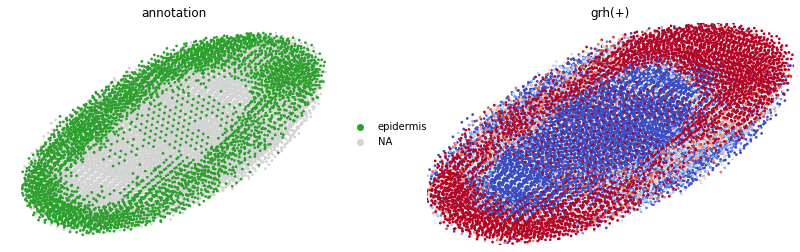

In [85]:
sc.pl.embedding(
                 adata_aucell,
                 basis='spatial',
                 color=['annotation','grh(+)'],
                 size=30,
                 colorbar_loc=None,
                 frameon=False,
                 vmin='p50',
                 vmax='p70',
                 cmap='coolwarm',
                 show=False,
                 groups='epidermis'
                    )
axs.set_aspect('equal')
axs.invert_xaxis()
plt.xlim([np.min(adata_aucell.obsm['spatial'], axis=0)[0], np.max(adata_aucell.obsm['spatial'], axis=0)[0]])
plt.ylim([np.min(adata_aucell.obsm['spatial'], axis=0)[1], np.max(adata_aucell.obsm['spatial'], axis=0)[1]])
plt.tight_layout()

E:\Anaconda\envs\sparcl\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\123\AppData\Local\Temp\ipykernel_5776\30137340.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


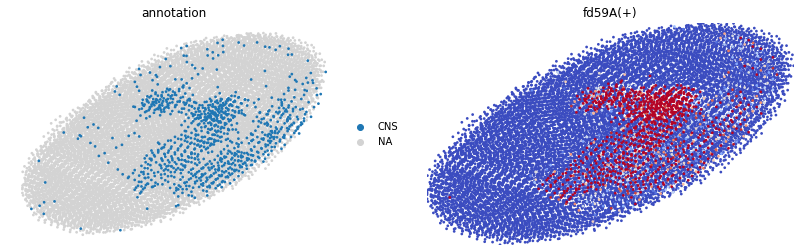

In [95]:
sc.pl.embedding(
                 adata_aucell,
                 basis='spatial',
                 color=['annotation','fd59A(+)'],
                 size=30,
                 colorbar_loc=None,
                 frameon=False,
                 vmin='p90',
                 vmax='p95',
                 cmap='coolwarm',
                 show=False,
                 groups='CNS'
                    )
axs.set_aspect('equal')
axs.invert_xaxis()
plt.xlim([np.min(adata_aucell.obsm['spatial'], axis=0)[0], np.max(adata_aucell.obsm['spatial'], axis=0)[0]])
plt.ylim([np.min(adata_aucell.obsm['spatial'], axis=0)[1], np.max(adata_aucell.obsm['spatial'], axis=0)[1]])
plt.tight_layout()

E:\Anaconda\envs\sparcl\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\123\AppData\Local\Temp\ipykernel_5776\3742951034.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


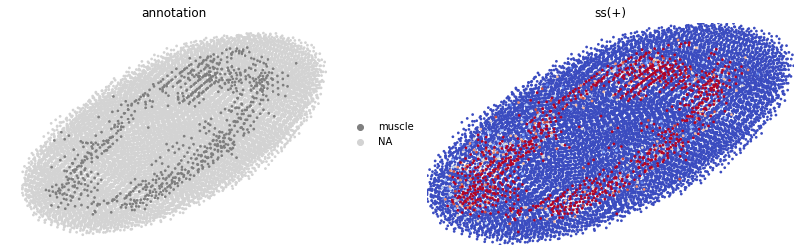

In [96]:
sc.pl.embedding(
                 adata_aucell,
                 basis='spatial',
                 color=['annotation','ss(+)'],
                 size=30,
                 colorbar_loc=None,
                 frameon=False,
                 vmin='p90',
                 vmax='p95',
                 cmap='coolwarm',
                 show=False,
                 groups='muscle'
                    )
axs.set_aspect('equal')
axs.invert_xaxis()
plt.xlim([np.min(adata_aucell.obsm['spatial'], axis=0)[0], np.max(adata_aucell.obsm['spatial'], axis=0)[0]])
plt.ylim([np.min(adata_aucell.obsm['spatial'], axis=0)[1], np.max(adata_aucell.obsm['spatial'], axis=0)[1]])
plt.tight_layout()